## Dependencies & Data

In [1]:
!solc-select install 0.8.20
!solc-select use 0.8.20
!solc --version

Installing solc '0.8.20'...
Version '0.8.20' installed.
Switched global version to 0.8.20
solc, the solidity compiler commandline interface
Version: 0.8.20+commit.a1b79de6.Darwin.appleclang


### Get Mock Price Data

In [2]:
import datetime
import requests
import pandas as pd


start_time = int(datetime.datetime(2017, 1, 1).timestamp() * 1000)
end_time = int(
    datetime.datetime.now()
    .replace(hour=0, minute=0, second=0, microsecond=0)
    .timestamp() * 1000
) + 86400000

params = {
    'symbol': 'ETHUSDT',
    'interval': '1d',
    'startTime': start_time,
    'endTime': end_time
}

ranges = []

current_year = datetime.datetime.fromtimestamp(start_time / 1000).year
current_year_start = start_time

while current_year < datetime.datetime.fromtimestamp(end_time / 1000).year:
    next_year_start = int(datetime.datetime(current_year + 1, 1, 1).timestamp() * 1000)
    ranges.append((current_year_start, next_year_start))
    current_year += 1
    current_year_start = next_year_start

ranges.append((current_year_start, end_time))


dfs = []
for time_range in ranges:
    params['startTime'] = time_range[0]
    params['endTime'] = time_range[1]
    # check for cache first
    response = requests.get('https://api.binance.us/api/v3/klines', params=params)
    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame(
        data,
        columns=[
            'open_time',
            'open',
            'high',
            'low',
            'close',
            'volume',
            'close_time',
            'quote_asset_volume',
            'number_of_trades',
            'taker_buy_base_asset_volume',
            'taker_buy_quote_asset_volume',
            'ignore'
            ]
        )
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[[
        'open',
        'high',
        'low',
        'close',
        'volume'
    ]].apply(pd.to_numeric)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by='open_time')

### Preprocess Data

Note: _Preprocessing outside of the neural network creates a vulnerability where a dishonest actor could manipulate the preprocessing steps. In production, this should be handled through Brevis, or included in the model architecture itself._

In [3]:
# Calculate returns
df['return'] = (df['close'] - df['open']) / df['open']
average_returns = df["return"].mean()
cumulative_returns = (df["return"] + 1).prod() - 1
df['excess_return'] = df['return'] - average_returns

# Rename columns
df = df.rename(columns={'open_time': 'date'})
df = df.rename(columns={'open': 'spot'})

# Reduce columns
df = df[['date', 'spot', 'return', 'excess_return']]

# Preprocess data by adding some rolling features
df['moving_average_10d'] = df['spot'].rolling(window=10).mean()
df['moving_average_30d'] = df['spot'].rolling(window=30).mean()
df['historical_volatility_10d'] = df['spot'].rolling(window=10).std()
df['historical_volatility_30d'] = df['spot'].rolling(window=30).std()

### Add Mock Liquidation Level for Short Calls
Note: _For proof-of-concept, we are setting the liquidation level target as **Max spot over next 10 days**_

In [28]:
# For simplicity, set the liquidation level to the MAX price of the next 10 days
df['liquidation_level'] = df['spot'].shift(-9).rolling(window=10).max()
df = df.dropna()

df.tail(20)

,spot,return,excess_return,moving_average_10d,moving_average_30d,historical_volatility_10d,historical_volatility_30d,liquidation_level
date,,,,,,,,
2024-01-25,2236.05,-0.006731,-0.009427,2432.960,2383.089333,123.743586,129.204543,2343.83
2024-01-26,2219.85,0.021745,0.019049,2403.145,2382.684667,136.262412,129.712117,2343.83
2024-01-27,2268.42,-0.000168,-0.002864,2371.213,2379.225333,125.160337,131.374595,2343.83
2024-01-28,2267.75,-0.004414,-0.007110,2344.800,2376.722667,114.939709,132.799235,2343.83
2024-01-29,2259.40,0.025719,0.023023,2323.681,2375.408000,108.479463,133.788371,2373.11
2024-01-30,2317.57,0.010973,0.008277,2305.648,2376.298000,89.655723,133.294503,2426.38
2024-01-31,2343.83,-0.024682,-0.027378,2292.749,2378.392000,70.072093,132.235179,2426.38
2024-02-01,2289.08,0.006055,0.003359,2275.915,2376.709333,39.796667,133.064919,2489.77
2024-02-02,2303.45,0.002318,-0.000378,2274.801,2374.953333,38.735546,133.691980,2501.58


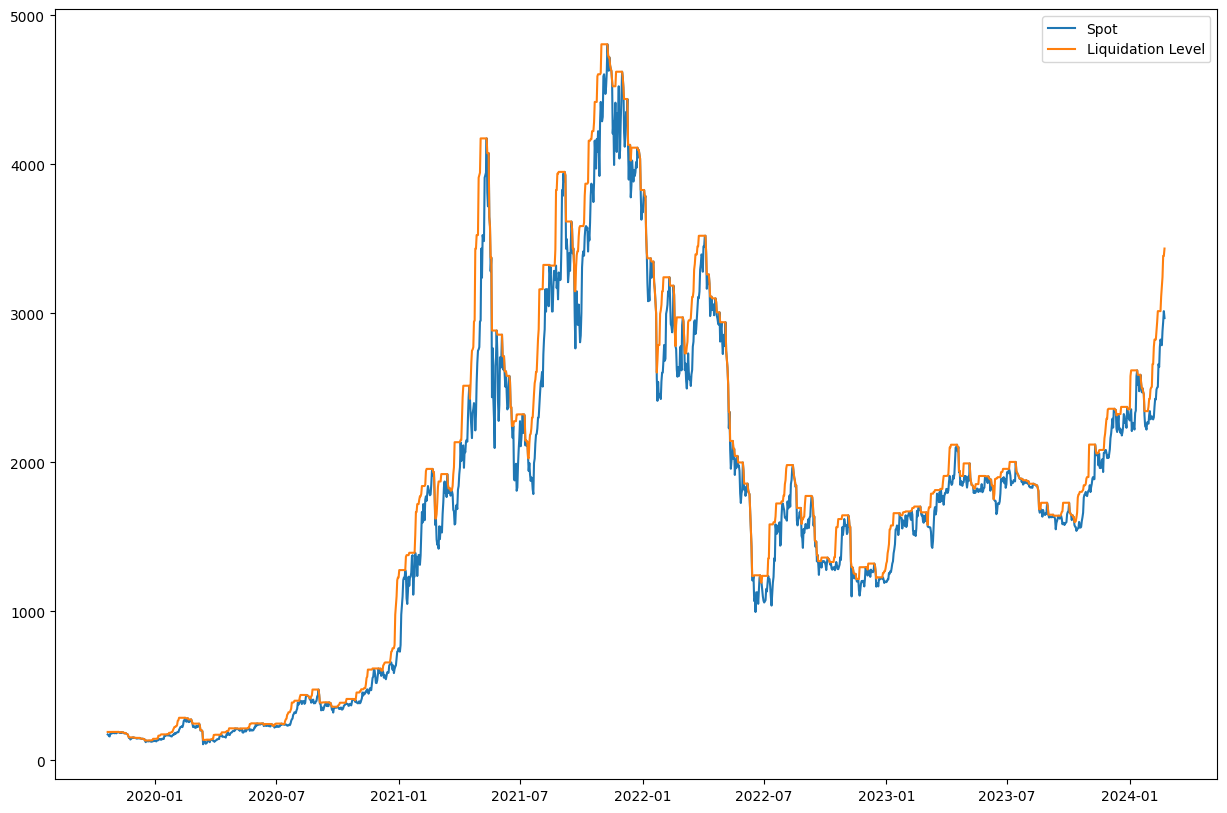

In [5]:
# Plot spot & liquidation level
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(df['date'], df['spot'], label='Spot')
plt.plot(df['date'], df['liquidation_level'], label='Liquidation Level')
plt.legend()
plt.show()


In [6]:
# Save the df to a csv file
df.to_csv('ethusdt_preprocessed.csv', index=False)

## Load preprocessed data

In [7]:
import pandas as pd
df = pd.read_csv('ethusdt_preprocessed.csv')

## Train a neural network to predict liquidation levels for short calls

In [8]:
# TODO: EVM-Storage + Brevis integration to prove
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

features = df[['spot', 'return', 'excess_return',
               'moving_average_10d', 'moving_average_30d',
               'historical_volatility_10d', 'historical_volatility_30d']]
target = df['liquidation_level']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1)).flatten()  # Rescale target as well

X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32)).view(-1, 1)
y_test_tensor = torch.tensor(y_test.astype(np.float32)).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Preprocessed test cases as a list of tensors
X_test_tensor[:10]

tensor([[0.2564, 0.6934, 0.6934, 0.2638, 0.2510, 0.0914, 0.1990],
        [0.0599, 0.6057, 0.6057, 0.0539, 0.0588, 0.0209, 0.0367],
        [0.3152, 0.6320, 0.6320, 0.3282, 0.3464, 0.0327, 0.0426],
        [0.0627, 0.6756, 0.6756, 0.0590, 0.0576, 0.0085, 0.0181],
        [0.0145, 0.6104, 0.6104, 0.0096, 0.0044, 0.0041, 0.0143],
        [0.4750, 0.6373, 0.6373, 0.4807, 0.4957, 0.0592, 0.0774],
        [0.2511, 0.5932, 0.5932, 0.2924, 0.2983, 0.2639, 0.2119],
        [0.3812, 0.6112, 0.6112, 0.3787, 0.3568, 0.1632, 0.2281],
        [0.4076, 0.6744, 0.6744, 0.4587, 0.5874, 0.3370, 0.5527],
        [0.0641, 0.6513, 0.6513, 0.0644, 0.0539, 0.0288, 0.0735]])

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
    Simple feedforward neural network with 3 layers
    """
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(scaled_features.shape[1], 64)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(64, 32)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(32, 1)  # Second hidden layer to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Linear activation for regression
        return x

model = Net()


In [12]:
model

Net(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
if True:

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    epochs = 100
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')



Epoch 1/100, Loss: 0.0209
Epoch 2/100, Loss: 0.0045
Epoch 3/100, Loss: 0.0010
Epoch 4/100, Loss: 0.0011
Epoch 5/100, Loss: 0.0021
Epoch 6/100, Loss: 0.0008
Epoch 7/100, Loss: 0.0015
Epoch 8/100, Loss: 0.0006
Epoch 9/100, Loss: 0.0022
Epoch 10/100, Loss: 0.0004
Epoch 11/100, Loss: 0.0007
Epoch 12/100, Loss: 0.0014
Epoch 13/100, Loss: 0.0023
Epoch 14/100, Loss: 0.0011
Epoch 15/100, Loss: 0.0006
Epoch 16/100, Loss: 0.0013
Epoch 17/100, Loss: 0.0005
Epoch 18/100, Loss: 0.0009
Epoch 19/100, Loss: 0.0009
Epoch 20/100, Loss: 0.0009
Epoch 21/100, Loss: 0.0012
Epoch 22/100, Loss: 0.0016
Epoch 23/100, Loss: 0.0004
Epoch 24/100, Loss: 0.0010
Epoch 25/100, Loss: 0.0003
Epoch 26/100, Loss: 0.0004
Epoch 27/100, Loss: 0.0006
Epoch 28/100, Loss: 0.0011
Epoch 29/100, Loss: 0.0011
Epoch 30/100, Loss: 0.0006
Epoch 31/100, Loss: 0.0006
Epoch 32/100, Loss: 0.0005
Epoch 33/100, Loss: 0.0004
Epoch 34/100, Loss: 0.0011
Epoch 35/100, Loss: 0.0012
Epoch 36/100, Loss: 0.0019
Epoch 37/100, Loss: 0.0006
Epoch 38/1

Test Loss: 0.0008817009511403739


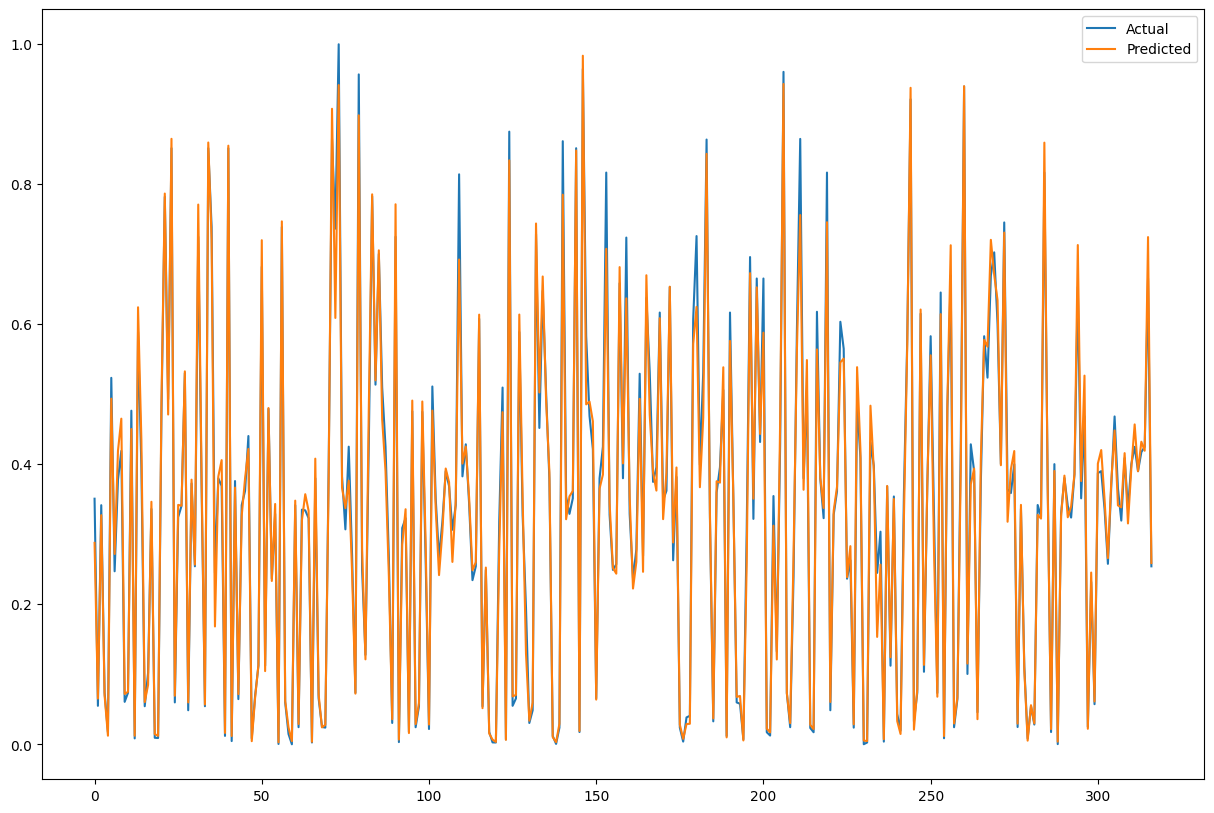

In [14]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

# Convert predictions to a numpy array for plotting
predictions_np = predictions.numpy().flatten()

# Visualize the actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_test, label='Actual')
plt.plot(predictions_np, label='Predicted')
plt.legend()
plt.show()


# EZKL

In [15]:
import os
import json
import ezkl

# Specify all the files we need
model_path = os.path.join('saved_models/network.onnx')
compiled_model_path = os.path.join('saved_models/network.ezkl')
pk_path = os.path.join('saved_models/test.pk')
vk_path = os.path.join('saved_models/test.vk')
settings_path = os.path.join('saved_models/settings.json')

witness_path = os.path.join('saved_models/witness.json')
data_path = os.path.join('saved_models/input.json')
cal_data_path = os.path.join('saved_models/cal_data.json')

In [16]:
model

Net(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [17]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# Set x to a random model input from the test set
x = torch.randn(1, 7)

# Flips the neural net into inference mode
model.eval()
model.to('cpu')

# Export the model
torch.onnx.export(model,               # model being run
                  x,                   # model input (or a tuple for multiple inputs)
                  model_path,            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})


data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

# Serialize data into file:
json.dump(data, open(data_path, 'w'))

In [18]:
!RUST_LOG=trace
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

In [19]:
# Use the test set to calibrate the circuit
cal_data = dict(input_data = X_test.tolist())

# Serialize calibration data into file:
json.dump(cal_data, open(cal_data_path, 'w'))

# Optimize for resources, we cap logrows at 12 to reduce setup and proving time, at the expense of accuracy
# You may want to increase the max logrows if accuracy is a concern
res = ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources", max_logrows = 12, scales = [2])




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+------------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error  | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+------------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.19785643 | 0.19785643   | 0.19785643 | 0.19785643 | 0.19785643     | 0.19785643       | 0.19785643    | 0.19785643    | 0.039147165        | 0.68771744         | 0.68771744             |
+------------+--------------+------------+------------+----------------+------------------+---------------+--------

In [20]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [21]:
res = ezkl.get_srs( settings_path)

In [22]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [23]:
# Generate the Witness for the proof

witness_path = os.path.join('saved_models/witness.json')

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [24]:
# Generate the proof

proof_path = os.path.join('saved_models/proof.json')

proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(proof)
assert os.path.isfile(proof_path)

{'instances': [['4200000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x2cda790cc254e632f5107de748cb33065be1c25082121678c0b7b625b82c79e32472832812f31ae84ce4f53fbd513c81a82a365c23f1a7b651b936680b101501214b0a3e76d27d8b14ddb5d94366fca7097fbc94925e01f8a021891d759bcb6707667eac768894c7e3fcd5354f8d0259396af24a4abe921d1914da67a1947b0c248711a6e4e45171e75395b0b01cef775c872d5d76b556280e3ecfa5e3e38fb202652a73dfd9388f7cf21d1495fc27dd6e14d83bad12c26f7fd62321151e7e0b30414e946e694cfa64d4eaabf9284d5e9b0aee2680b40809200780fa922f5cfc17f755849e82a5add4f6b457a8174de768023828ed9fd912250f731f4fb4b4ef0aab8b698b403920e12a85cdfa53a4b7487a08f3dbfefca28dc13b3ef08866c10fb8a4eb0def8651c7bc4fed49756131d81422d69ec2f9b895d067ceeee758ef102045d7f6eae5def18ade25327ab7c615cd159fc73a695fd5fffb64b906016119857ee47a603c569e1efb9072c7108f07f2a6504267b348e9944cc919844f5d20cc71e6ce68f16e4180e4c96dc8ecffd4c4eef11dc5a32c640f9d0ca191de832df4d95ec588a20cc58fcedc32a31733c2ad8f9fd77d57db02fca36d4361ecd8191285

In [25]:
# Verify the proof

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

verified


# Deploying the Verifier

In [26]:
sol_code_path = os.path.join('saved_models/Verifier.sol')
abi_path = os.path.join('saved_models/Verifier.abi')

res = ezkl.create_evm_verifier(
        vk_path,
        
        settings_path,
        sol_code_path,
        abi_path
    )

assert res == True
assert os.path.isfile(sol_code_path)

In [27]:
onchain_input_array = []

# using a loop
# avoiding printing last comma
formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += str(onchain_input_array[-1])
        if j != len(value) - 1:
            formatted_output += ", "
    formatted_output += "]"

# This will be the values you use onchain
# Copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  [0x0000000000000000000000000000000000000000000000000000000000000042]
proof:  0x2cda790cc254e632f5107de748cb33065be1c25082121678c0b7b625b82c79e32472832812f31ae84ce4f53fbd513c81a82a365c23f1a7b651b936680b101501214b0a3e76d27d8b14ddb5d94366fca7097fbc94925e01f8a021891d759bcb6707667eac768894c7e3fcd5354f8d0259396af24a4abe921d1914da67a1947b0c248711a6e4e45171e75395b0b01cef775c872d5d76b556280e3ecfa5e3e38fb202652a73dfd9388f7cf21d1495fc27dd6e14d83bad12c26f7fd62321151e7e0b30414e946e694cfa64d4eaabf9284d5e9b0aee2680b40809200780fa922f5cfc17f755849e82a5add4f6b457a8174de768023828ed9fd912250f731f4fb4b4ef0aab8b698b403920e12a85cdfa53a4b7487a08f3dbfefca28dc13b3ef08866c10fb8a4eb0def8651c7bc4fed49756131d81422d69ec2f9b895d067ceeee758ef102045d7f6eae5def18ade25327ab7c615cd159fc73a695fd5fffb64b906016119857ee47a603c569e1efb9072c7108f07f2a6504267b348e9944cc919844f5d20cc71e6ce68f16e4180e4c96dc8ecffd4c4eef11dc5a32c640f9d0ca191de832df4d95ec588a20cc58fcedc32a31733c2ad8f9fd77d57db02fca36d4361ecd819128504d969b